## parameters

In [25]:
import numpy as np
import random
import csv
import time
import matplotlib.pyplot as plt

# Define Bat Algorithm parameters
num_bats = 100
max_iterations = 200
frequency_min = 0.0
frequency_max = 2.5
alpha = 0.97
gamma = 0.9
initial_loudness = 1.0
initial_pulse_rate = 0.5


## fitness function

In [26]:
def fitness(data, position, label, dimensions):
    distances = 0
    for row in data:
        if row['class'] == label:
            distance = sum((row[dim] - pos) ** 2 for dim, pos in zip(dimensions, position)) ** 0.5
            distances += distance
    return distances

### in the context of multiple dimensions, 'position' might contain more than 2 values; should handle any number of dimensions

## Bat Algorithm function

In [27]:
def BatAlgorithm(data, label, dimensions, search_space):
    # Initialize bat positions randomly within search space
    positions = np.random.uniform(low=search_space[0], high=search_space[1], size=(num_bats, len(dimensions)))
    velocities = np.zeros_like(positions)
    frequencies = np.zeros(num_bats)
    loudness = np.full(num_bats, initial_loudness)
    pulse_rate = np.full(num_bats, initial_pulse_rate)

    # Initialize the global best position
    gbest_position = positions[np.argmin([fitness(data, pos, label, dimensions) for pos in positions])]
    gbest_fitness = fitness(data, gbest_position, label, dimensions)
    tolerance = 0.001
    
    fitness_over_time = []

    # Main loop of the Bat Algorithm
    for iteration in range(max_iterations):
        for i in range(num_bats):
            frequencies[i] = frequency_min + (frequency_max - frequency_min) * random.random()
            velocities[i] += (positions[i] - gbest_position) * frequencies[i]
            positions[i] += velocities[i]

            if random.random() > pulse_rate[i]:
                positions[i] = gbest_position + 0.001 * np.random.randn(len(dimensions))
                
            # Ensure positions are within bounds
            positions[i] = np.clip(positions[i], search_space[0], search_space[1])

            # Evaluate fitness and update personal and global bests
            current_fitness = fitness(data, positions[i], label, dimensions)
            if current_fitness < gbest_fitness and loudness[i] > random.random():
                gbest_position = positions[i].copy()
                gbest_fitness = current_fitness
                loudness[i] *= alpha
                pulse_rate[i] *= (1 - np.exp(-gamma * iteration))

        fitness_over_time.append(gbest_fitness)

        # Early stopping condition
        if gbest_fitness < tolerance:
            break

    return gbest_position, fitness_over_time  # Return the final global best position and fitness over time


## read the dataset

In [28]:
def read_dataset(filename):
    with open(filename, mode='r') as file:
        reader = csv.DictReader(file)
        data = []
        for row in reader:
            row_data = {key: float(value) if key != 'class' else value for key, value in row.items()}
            data.append(row_data)
        return data

## compute centroids for each class label

In [29]:
def compute_centroids(data, label, dimensions, search_space):
    centroid, fitness_over_time = BatAlgorithm(data, label, dimensions, search_space)
    return centroid, fitness_over_time


## main script 

In [30]:
start_time = time.time()
dataset = read_dataset('/Users/angelesmarin/Desktop/3Class_5Feature_dataset.csv')

dimension_keys = [key for key in dataset[0].keys() if key != 'class']
search_space = (0, 100)  # Set search space boundaries for all dimensions

labels = set(row['class'] for row in dataset)
centroids = {label: compute_centroids(dataset, label, dimension_keys, search_space) for label in labels}

print("Final Centroids:")
for label, (centroid, _) in centroids.items():
    print(f"Label {label}: {centroid}")

print(f"Time taken (seconds): {time.time() - start_time}")

Final Centroids:
Label C: [48.49279281 44.11992716 44.67377771 55.28642194 49.93719365]
Label A: [68.14531322 61.89682402 46.52838682 41.83818443 58.68363363]
Label B: [53.59090405 45.53087038 55.96360153 58.55139031 47.66465833]
Time taken (seconds): 34.92602491378784


## fitness function values over iterations

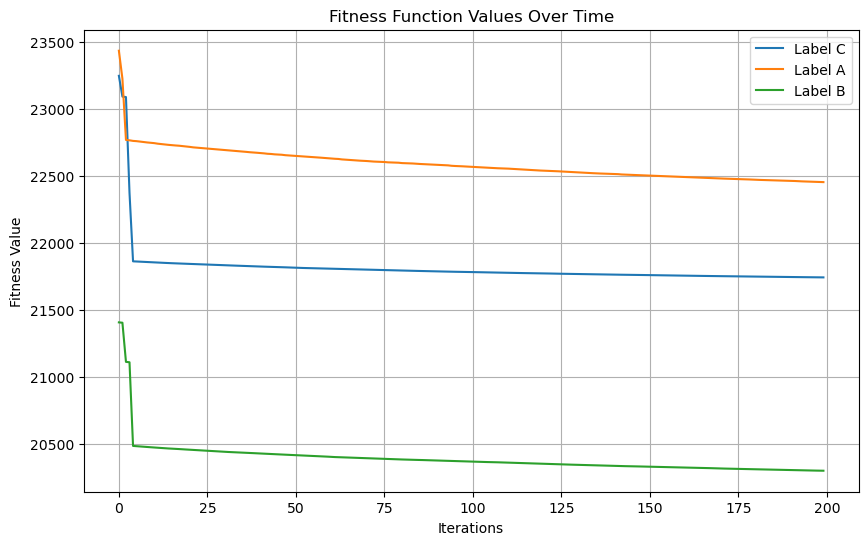

In [37]:
plt.figure(figsize=(10, 6))
for label, (_, fitness_over_time) in centroids.items():
    plt.plot(fitness_over_time, label=f'Label {label}')
plt.xlabel('Iterations')
plt.ylabel('Fitness Value')
plt.title('Fitness Function Values Over Time')
plt.legend()
plt.grid(True)
plt.show()


### Fitness value measues how well the centroid fits the data. Lower fitness value = better solution 

### Sharp decline menas bat algorithm quickly finds better solutions to improve centroids' position 